In [1]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import shutil
from keras.models import Sequential
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras import backend as K
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path_train="train"
path_valid="valid"
path_test="test"

Number of images of Cercospora leaf spot: 210 || Number of images of Diseased Fruit: 40 || Number of images of Healthy: 188 || Number of images of Healthy Fruit: 93 || Number of images of Powdery Mildew: 28 || Total number of images we have 559


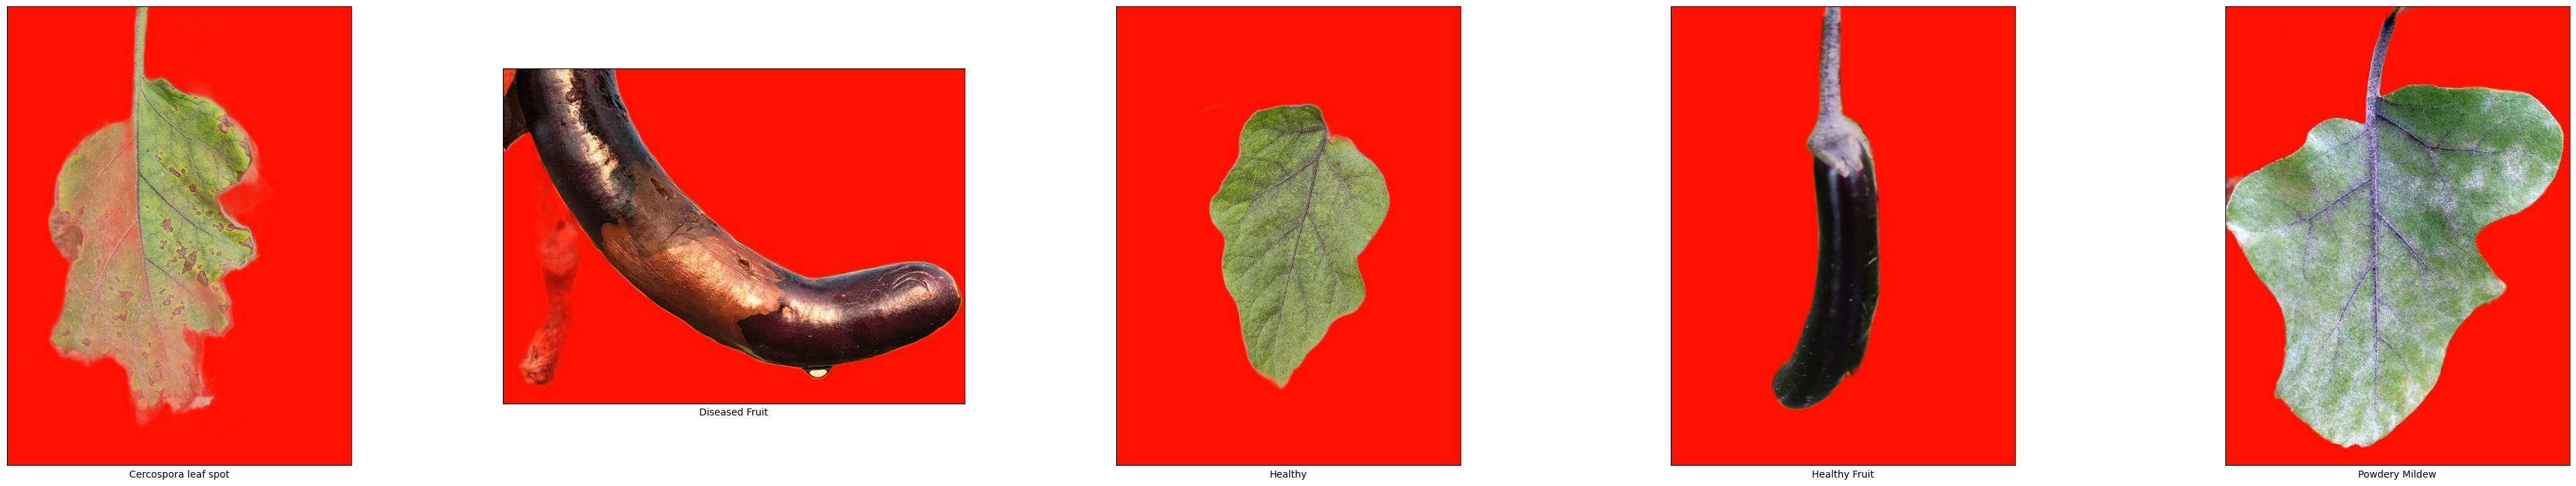

In [3]:
path=path_train
plt.figure(figsize=(70,70))
count=0
plant_names=[]
total_images=0
for i in os.listdir(path):
  count+=1
  plant_names.append(i)
  plt.subplot(7,7,count)

  images_path=os.listdir(path+"/"+i)
  print("Number of images of "+i+":",len(images_path),"||",end=" ")
  total_images+=len(images_path)

  image_show=plt.imread(path+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i)
  
  plt.xticks([])
  plt.yticks([])


print("Total number of images we have",total_images)  

In [4]:
print(plant_names)
print(len(plant_names))
classes=len(plant_names)

['Cercospora leaf spot', 'Diseased Fruit', 'Healthy', 'Healthy Fruit', 'Powdery Mildew']
5


In [5]:
#Image augmentation
train_datagen= ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  width_shift_range=0.2,
                                  height_shift_range=0.2)

val_datagen=ImageDataGenerator()

train= train_datagen.flow_from_directory(directory=path_train,
                                         batch_size=32,
                                         target_size=(224,224),
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         seed=42)

valid=val_datagen.flow_from_directory(directory=path_valid,
                                      batch_size=32,
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode='categorical')

Found 559 images belonging to 5 classes.
Found 68 images belonging to 5 classes.


In [6]:
# Assuming you have a separate test dataset
test_datagen = ImageDataGenerator()
test = test_datagen.flow_from_directory(
    directory=path_test,
    batch_size=32,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Get the class labels from the generator
class_labels = list(test.class_indices.keys())

Found 75 images belonging to 5 classes.


In [8]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
inceptionV3_base_model_tf = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3), classes=classes)

#Model building
inceptionV3_base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
base_model=inceptionV3_base_model_tf(x,training=False)
base_model=GlobalAveragePooling2D()(base_model)
base_model=Dense(128,activation='relu')(base_model)
base_model=Dense(64,activation='relu')(base_model)
base_model=Dense(classes,activation='softmax')(base_model)


model_inceptionV3=Model(inputs=pt,outputs=base_model)
model_inceptionV3.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [18]:
!mkdir inceptionV3

In [17]:
# !rm -r inceptionV3

In [14]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=7, mode='auto')
lr = ReduceLROnPlateau(monitor='val_accuracy', verbose=1, patience=5, min_lr=0.001)

In [20]:
model_inceptionV3.compile(optimizer='Adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [21]:
mc = ModelCheckpoint(filepath='/kaggle/working/inceptionV3', monitor='val_accuracy', verbose=1, save_best_only=True)
history = model_inceptionV3.fit(train,
                 validation_data=valid,
                 epochs=30,
                 steps_per_epoch=10,
                 callbacks=[es, mc, lr],
                 verbose=1)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 4.8373 - accuracy: 0.3812
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /kaggle/working/inceptionV3
10/10 [==============================] - 69s 7s/step - loss: 4.8373 - accuracy: 0.3812 - val_loss: 2.4056 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 2.1129 - accuracy: 0.5344
Epoch 2: val_accuracy improved from 0.50000 to 0.58824, saving model to /kaggle/working/inceptionV3
10/10 [==============================] - 62s 7s/step - loss: 2.1129 - accuracy: 0.5344 - val_loss: 1.4038 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.4927 - accuracy: 0.5710
Epoch 3: val_accuracy did not improve from 0.58824
10/10 [==============================] - 25s 3s/step - loss: 1.4927 - accuracy: 0.5710 - val_loss: 1.2445 - val_accuracy: 0.5588 - lr: 0.0010
Epoch 4/30
10/10 [==========================

In [27]:
scores = model_inceptionV3.evaluate(test)

3/3 [==============================] - 5s 1s/step - loss: 1.1295 - accuracy: 0.6800


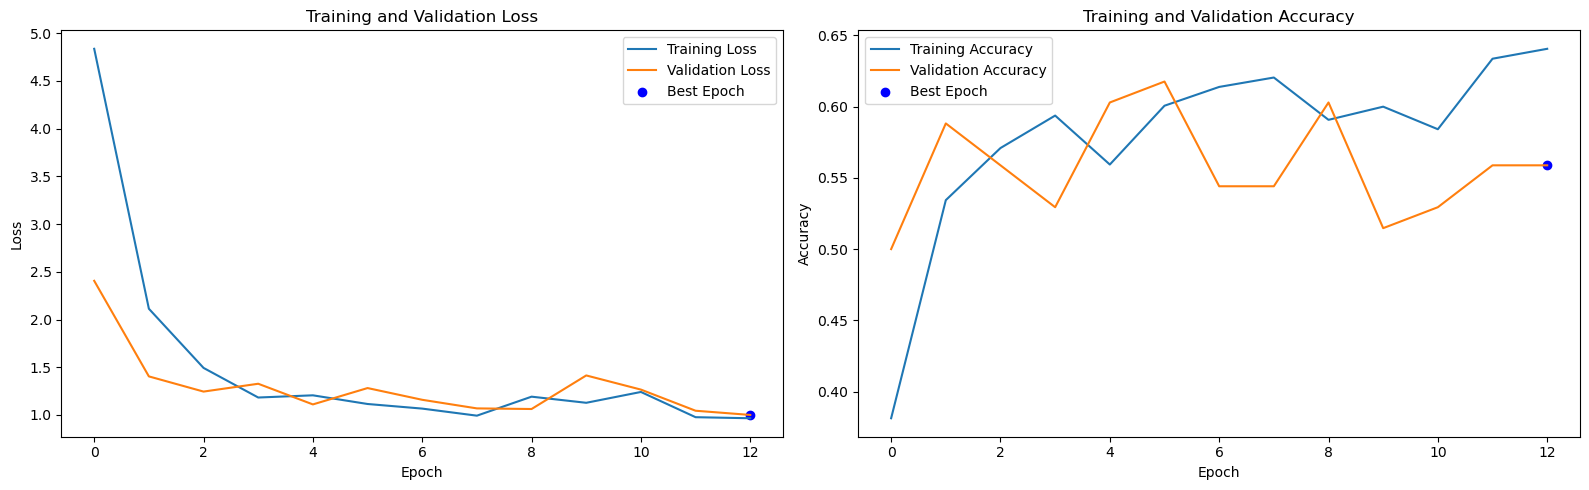

In [28]:
import matplotlib.pyplot as plt
import numpy as np
# Get the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Find the index of the best epoch based on validation loss
best_epoch = np.argmin(val_loss)

# Plot the training and validation loss curves side by side
plt.figure(figsize=(16, 5))

# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.scatter(best_epoch, val_loss[best_epoch], color='blue', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.scatter(best_epoch, val_acc[best_epoch], color='blue', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

3/3 [==============================] - 5s 1s/step


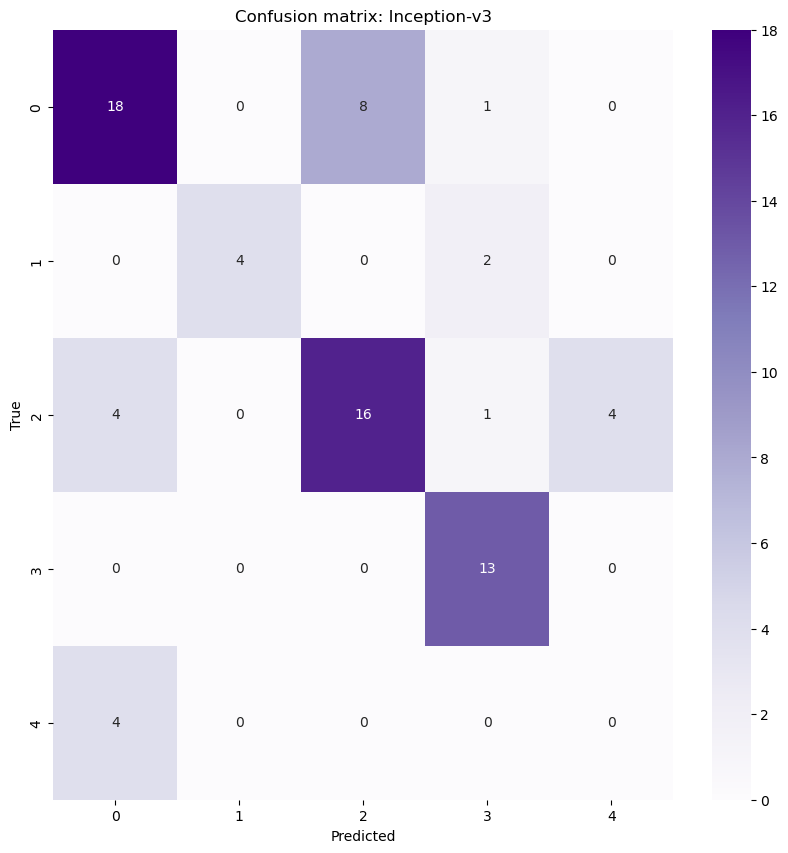

                      precision    recall  f1-score   support

Cercospora leaf spot       0.69      0.67      0.68        27
      Diseased Fruit       1.00      0.67      0.80         6
             Healthy       0.67      0.64      0.65        25
       Healthy Fruit       0.76      1.00      0.87        13
      Powdery Mildew       0.00      0.00      0.00         4

            accuracy                           0.68        75
           macro avg       0.62      0.59      0.60        75
        weighted avg       0.68      0.68      0.68        75



In [29]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model=model_inceptionV3
y_pred = model.predict(test)
y_true = test.classes

# Convert predictions to class indices
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix: Inception-v3')
plt.show()

# Generate the classification report with class names
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)